In [38]:
from fastai.tabular.all import *
from datetime import datetime,timedelta
from dotenv import load_dotenv
from google.cloud import bigquery
import os
sys.path.append('../')
from lib.fetcher import fetch

In [55]:
# Load secrets from environment variables to avoid showing them in shared notebook snapshots
load_dotenv(dotenv_path='/storage/.env')

# Define variables
var_actor_login = 'chillu'
var_bigquery_table = 'silverstripe.com:api-project-617183295772.github_silverstripe_events.events_chillu'
var_date_cutoff=(datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d')
var_results_path='/storage/results.csv'

In [56]:
# https://towardsdatascience.com/normalization-vs-standardization-cb8fe15082eb
def normalise(x):
    return (x-min(x))/(max(x)-min(x))

In [57]:
def preprocess(df):
    # Fill missing values with zeroes
    df = df.fillna(value=0)
    # Clip outliers in scoring inputs to provide a better range to the regression
    df['actor_events_count'].clip(upper=3, inplace=True)
    df['actor_comments_count'].clip(upper=3, inplace=True)
    df['actor_comments_body_count'].clip(upper=100, inplace=True)
    return df

In [58]:
# Fetch results if not already present
if os.path.isfile(var_results_path):
    df = pd.read_csv('../storage/results.csv')
else:
    client = bigquery.Client()

    query = ("""
    WITH
    all_events AS (
      SELECT *
      FROM `{var_bigquery_table}`
    ),
    opened_events AS (
      SELECT *
      FROM `{var_bigquery_table}`
      WHERE type IN ('IssuesEvent', 'PullRequestEvent') AND action = 'opened' 
      ORDER BY created_at ASC
    ),
    actor_events AS (
      SELECT *
      FROM `{var_bigquery_table}`
      WHERE actor_login = '{var_actor_login}'
      ORDER BY created_at ASC
    ),
    repo_event_counts_by_actor AS (
      SELECT
      repo_id,
      actor_login,
      COUNT(*) AS event_count
      FROM `{var_bigquery_table}`
      GROUP BY 1,2
    )

    SELECT DISTINCT
    # Leading indicators (available on new items)
    opened_events.item_id,
    opened_events.item_url,
    opened_events.org_id,
    opened_events.repo_id,
    opened_events.actor_login,
    opened_events.type,
    opened_events.created_at,
    opened_events.is_at_mentioned,
    opened_events.title_chars_count,
    opened_events.body_chars_count,
    opened_events.markdown_chars_count,
    # Scoring indicators
    COUNTIF(all_events.actor_login = '{var_actor_login}') AS actor_events_count,
    COUNTIF(all_events.is_comment = true AND all_events.actor_login = '{var_actor_login}') AS actor_comments_count,
    (
      SELECT
        COUNT(*)
      FROM all_events all_events_inner
      WHERE
        opened_events.repo_id = all_events_inner.repo_id
        AND all_events_inner.actor_login = opened_events.actor_login
        AND all_events_inner.created_at < opened_events.created_at
    ) AS prev_repo_creator_events_count,
    (
      SELECT
        COUNT(*)
      FROM actor_events
      WHERE
        opened_events.repo_id = actor_events.repo_id
        AND actor_events.created_at < opened_events.created_at
    ) AS prev_repo_actor_events_count,
    (
      SELECT
        event_count
      FROM repo_event_counts_by_actor
      WHERE
        opened_events.repo_id = repo_event_counts_by_actor.repo_id
        AND repo_event_counts_by_actor.actor_login = '{var_actor_login}'
    ) AS total_repo_actor_events_count,
    (
      SELECT
        event_count
      FROM repo_event_counts_by_actor
      WHERE
        opened_events.repo_id = repo_event_counts_by_actor.repo_id
        AND repo_event_counts_by_actor.actor_login = opened_events.actor_login
    ) AS total_repo_creator_events_count,
    # Trailing indicators (not available on newly created items)
    STRING_AGG(all_events.at_mentions) AS all_at_mentions,
    STRING_AGG(all_events.actor_login) AS all_actors,
    COUNT(all_events.id) AS events_count,
    COUNTIF(all_events.is_comment = true) AS comments_count,
    CHAR_LENGTH(STRING_AGG(all_events.body)) AS comments_body_count,
    SUM(all_events.at_mentions_count) AS at_mentions_count,
    COUNTIF(all_events.is_at_mentioned = true) AS actor_at_mentions_count,
    (SELECT CHAR_LENGTH(STRING_AGG(actor_events.body)) FROM actor_events WHERE opened_events.item_id = actor_events.item_id) AS actor_comments_body_count
    # Due to the nature of event streams, the opened event might not be in the source data set (cutoff by date filter)
    FROM opened_events
    LEFT JOIN all_events ON all_events.item_id = opened_events.item_id
    WHERE opened_events.created_at < '{var_date_cutoff}'
    GROUP BY 1,2,3,4,5,6,7,8,9,10,11
    ORDER BY opened_events.created_at ASC
    """.format(
        var_actor_login=var_actor_login,
        var_bigquery_table=var_bigquery_table,
        var_date_cutoff=var_date_cutoff
    ))
    df = client.query(query).to_dataframe()
    df.to_csv(var_results_path)

In [59]:
# Preview raw data
pd.set_option('display.max_columns', None)
df.head()

,Unnamed: 0,item_id,item_url,org_id,repo_id,actor_login,type,created_at,is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,actor_events_count,actor_comments_count,prev_repo_creator_events_count,prev_repo_actor_events_count,total_repo_actor_events_count,total_repo_creator_events_count,all_at_mentions,all_actors,events_count,comments_count,comments_body_count,at_mentions_count,actor_at_mentions_count,actor_comments_body_count
0,0,53209108,https://api.github.com/repos/silverstripe/silverstripe-framework/issues/3749,379348.0,1318892,tractorcow,IssuesEvent,2015-01-01 00:04:56+00:00,False,58,619.0,0.0,2,1,0,0,3126.0,9237,",,@sb-relaxt-at,,,,,@jonom","chillu,sb-relaxt-at,jonom,tractorcow,chillu,tractorcow,tractorcow,sb-relaxt-at",8,6,3192.0,2.0,0,1161.0
1,1,53245608,https://api.github.com/repos/silverstripe/silverstripe-cms/issues/1147,379348.0,1319183,jand000,IssuesEvent,2015-01-02 10:15:55+00:00,False,59,323.0,0.0,2,2,0,0,649.0,2,"@dhensby,@willmorgan,,,,@kinglozzer,,,,@jand000,@chillu,","chillu,dhensby,sminnee,tractorcow,jand000,tractorcow,dhensby,jand000,kinglozzer,chillu",10,8,5689.0,5.0,1,1810.0
2,2,26774248,https://api.github.com/repos/silverstripe/silverstripe-translatable/pulls/178,379348.0,1540453,dhensby,PullRequestEvent,2015-01-02 22:44:24+00:00,False,20,50.0,0.0,1,0,0,0,56.0,78,",","chillu,dhensby",2,0,101.0,0.0,0,50.0
3,3,26784769,https://api.github.com/repos/silverstripe/silverstripe-mssql/pulls/20,379348.0,1236917,dhensby,PullRequestEvent,2015-01-03 17:17:47+00:00,False,20,0.0,0.0,1,0,0,0,4.0,14,",","chillu,dhensby",2,0,1.0,0.0,0,0.0
4,4,26785071,https://api.github.com/repos/silverstripe-labs/silverstripe-staticpublisher/pulls/41,568043.0,5898270,dhensby,PullRequestEvent,2015-01-03 17:44:57+00:00,False,20,0.0,0.0,0,0,0,0,NaN,27,",","wilr,dhensby",2,0,1.0,0.0,0,NaN


In [8]:
# Duplicate any items without "temporal" data.
# The model should be able to perform well on newly created issues
# without penalising them for not having any events (yet)
temporal_overrides = {
  'events_count': 0,
  'comments_count': 0,
  'comments_body_count': 0,
}
df_fresh = df.copy().assign(**temporal_overrides)
# Avoid index clashes and make altered rows identifiable during validation
df_fresh['item_url'] = df_fresh['item_url']  + '__fresh'
df = df.append(df_fresh)
df = df.set_index('item_url')

In [9]:
df = preprocess(df)

In [10]:
# Preview some values used for scoring
scoring = {
    'actor_events_count': 1, 
    'actor_comments_count': 2, 
    'actor_comments_body_count': 1
}
scoring_fields = list(scoring.keys())

<AxesSubplot:>

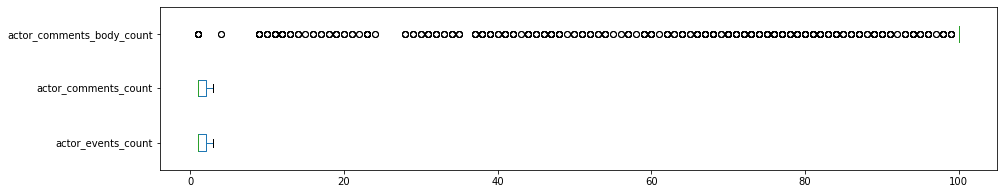

In [11]:
# Explore data distribution to get intuition on scoring
# Even after removing outliers in preprocessing,
# the two ranges have very different dimensionality without normalisation.
df[scoring_fields].where(df[scoring_fields] > 0).plot.box(vert=False,figsize=(15,3))

<AxesSubplot:>

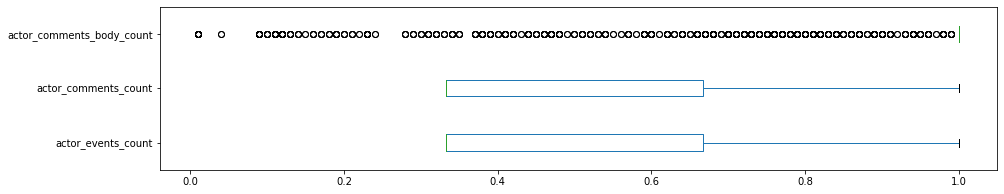

In [12]:
# Naive min-max normalisation to avoid one feature overly influencing the scoring
df[scoring_fields] = df[scoring_fields].apply(normalise)
df[scoring_fields].where(df[scoring_fields] > 0).plot.box(vert=False,figsize=(15,3))

In [13]:
# Calculate score with different weights
# TODO Use apply() and add()
scoring_weights = list(scoring.values())
df['score'] = normalise(
    df[scoring_fields[0]] * scoring_weights[0]
    + df[scoring_fields[1]] * scoring_weights[1]
    + df[scoring_fields[2]] * scoring_weights[2]
)
# TODO Fix block accuracy
#df['score'] = df['score'].apply(lambda x: 1 if x > 0 else 0)
df[scoring_fields + ['score']].sort_values(by='score', ascending=False).head()

,actor_events_count,actor_comments_count,actor_comments_body_count,score
item_url,,,,
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/4599,1.0,1.0,1.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/9274,1.0,1.0,1.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/9335,1.0,1.0,1.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/5612,1.0,1.0,1.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-asset-admin/issues/536__fresh,1.0,1.0,1.0,1.0


<AxesSubplot:>

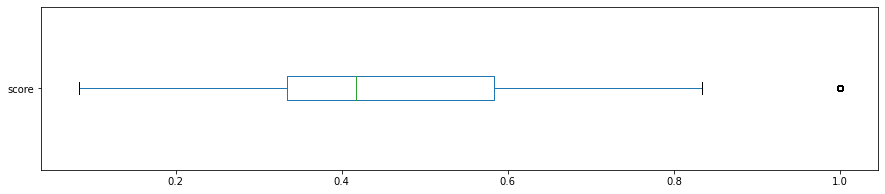

In [14]:
# Scoring distribution (excl. zeroes)
# It's skewed to lower scores, since low interactions are more common than high interactions
df['score'].where(df['score'] > 0).plot.box(vert=False,figsize=(15,3))

<AxesSubplot:ylabel='Frequency'>

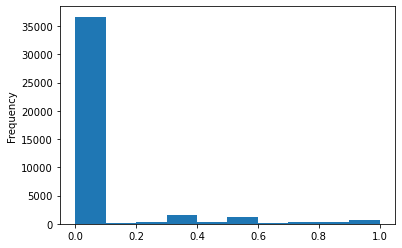

In [15]:
# Scoring histogram (incl. zeroes)
# There are way more items where the actor has never interacted (score=0)
df['score'].plot.hist()

In [16]:
# Percentage of rows where score=0
len(df[df['score'] == 0]) / len(df)

0.8762235401899803

In [17]:
# Don't include scoring_fields in here since that would be cheating
cat_names = [
  'org_id',
  'repo_id',
  'actor_login',
  'type',
  'is_at_mentioned',
]
cont_names = [
  'title_chars_count',
  'body_chars_count',
  'markdown_chars_count',
  'prev_repo_creator_events_count',
  'prev_repo_actor_events_count',
  'total_repo_creator_events_count',
  'total_repo_actor_events_count',
  'events_count',
  'comments_count',
  'comments_body_count',
  'actor_at_mentions_count',
  'at_mentions_count',
]

In [18]:
# Create fast.ai (PyTorch) data set
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
tp = TabularPandas(
    df,
    cat_names=cat_names,
    cont_names=cont_names,
    procs=[
      FillMissing,
      Categorify,
      Normalize
    ],
    y_names='score',
    #y_block=CategoryBlock,
    splits=splits
)

In [19]:
# Alternative approach: Decision trees
# Couldn't get accuracy above 0.51
# from sklearn import ensemble
# xs,y = tp.train.xs,tp.train.y
# valid_xs,valid_y = tp.valid.xs,tp.valid.y
# def rf(n_estimators=1000, max_samples=20000,
#        max_features=0.5, min_samples_leaf=20, **kwargs):
#     return ensemble.RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
#         max_samples=max_samples, max_features=max_features,
#         min_samples_leaf=min_samples_leaf, oob_score=True)
# model = rf()
# model.fit(xs, y)
# model.score(valid_xs, valid_y)

In [20]:
learn = tabular_learner(tp.dataloaders(bs=64), metrics=accuracy)

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=2.75422871709452e-06)

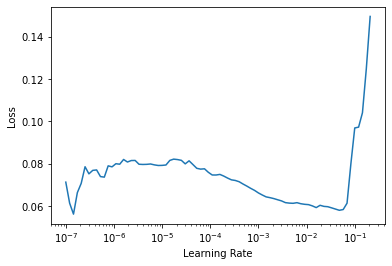

In [21]:
# Intuit the learning rate
learn.lr_find()

In [22]:
learn.fit_one_cycle(1, lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.021037,0.019612,0.881615,00:15


In [25]:
learn.show_results()

,org_id,repo_id,actor_login,type,is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,prev_repo_creator_events_count,prev_repo_actor_events_count,total_repo_creator_events_count,total_repo_actor_events_count,events_count,comments_count,comments_body_count,actor_at_mentions_count,at_mentions_count,score,score_pred
0,4.0,114.0,929.0,1.0,1.0,-0.554422,-0.072248,-0.201935,-0.307314,-0.570215,-0.354652,-0.712528,-0.491348,-0.292885,-0.288081,-0.123064,-0.293940,0.000000,-0.023530
1,4.0,118.0,929.0,2.0,1.0,0.606577,-0.365216,-0.067602,-0.039541,-0.547411,-0.128282,-0.681143,-0.019816,-0.292885,-0.277029,-0.123064,-0.293940,0.000000,0.023693
2,4.0,118.0,929.0,1.0,1.0,0.171202,0.642526,-0.201935,-0.117340,-0.554612,-0.128282,-0.681143,-0.491348,-0.292885,-0.288081,-0.123064,1.271513,0.000000,0.019996
3,1.0,112.0,69.0,2.0,1.0,-1.086546,-0.299916,-0.201935,-0.293744,-0.569014,-0.356281,-0.714023,-0.491348,-0.292885,-0.288081,-0.123064,0.227877,0.000000,0.000217
4,4.0,105.0,751.0,1.0,1.0,-1.425170,-0.077542,-0.067602,-0.048587,-0.324169,-0.149453,-0.535428,-0.019816,-0.030803,0.080307,-0.123064,-0.293940,0.000000,0.069656
5,4.0,20.0,929.0,2.0,1.0,1.477325,-0.224909,-0.201935,-0.014211,1.863833,0.943856,1.618912,-0.491348,-0.292885,-0.288081,-0.123064,-0.293940,0.000000,-0.006375
6,10.0,70.0,327.0,1.0,1.0,0.122827,0.485452,-0.201935,-0.319979,-0.558213,-0.392652,-0.658726,0.215950,0.231280,0.174860,-0.123064,0.227877,0.000000,-0.013945
7,16.0,30.0,541.0,2.0,1.0,-1.280046,-0.305211,-0.201935,-0.319979,-0.569014,-0.393195,-0.716264,-0.491348,-0.292885,-0.288081,-0.123064,-0.293940,0.000000,-0.012058
8,3.0,37.0,358.0,1.0,1.0,-0.893046,-0.276973,-0.201935,-0.319074,-0.569014,-0.392652,-0.715517,-0.491348,-0.292885,-0.288081,-0.123064,0.227877,0.333333,0.289677


In [26]:
interp = Interpretation.from_learner(learn)
top_losses = interp.top_losses()
to_top_losses = learn.dls.valid.dataset.iloc[top_losses.indices]
to_top_losses.show()

,org_id,repo_id,actor_login,type,is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,prev_repo_creator_events_count,prev_repo_actor_events_count,total_repo_creator_events_count,total_repo_actor_events_count,events_count,comments_count,comments_body_count,actor_at_mentions_count,at_mentions_count,score
item_url,,,,,,,,,,,,,,,,,,
https://api.github.com/repos/silverstripe/silverstripe-versioned-admin/issues/15__fresh,379348,124332817,robbieaverill,IssuesEvent,True,68.0,2013.0,10.0,53.0,0.0,280.0,39.0,0.0,0.0,0.0,6.0,29.0,0.0
https://api.github.com/repos/silverstripe/silverstripe-versioned/issues/177,379348,85634633,nglasl,IssuesEvent,False,27.0,539.0,0.0,4.0,166.0,15.0,249.0,69.0,67.0,42546.0,5.0,19.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/8228,379348,1318892,anishpixel,IssuesEvent,False,44.0,552.0,0.0,1.0,2543.0,5.0,3126.0,59.0,51.0,84075.0,4.0,32.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/4134__fresh,379348,1318892,camfindlay,PullRequestEvent,False,75.0,343.0,2.0,68.0,104.0,163.0,3126.0,0.0,0.0,0.0,0.0,4.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/7373__fresh,379348,1318892,dhensby,PullRequestEvent,False,39.0,456.0,0.0,4313.0,2116.0,5666.0,3126.0,0.0,0.0,0.0,0.0,0.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/6957__fresh,379348,1318892,unclecheese,PullRequestEvent,False,17.0,116.0,0.0,98.0,1831.0,594.0,3126.0,0.0,0.0,0.0,0.0,0.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/8945,379348,1318892,maxime-rainville,PullRequestEvent,False,57.0,89.0,2.0,666.0,2867.0,1052.0,3126.0,5.0,3.0,615.0,0.0,0.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/issues/8346__fresh,379348,1318892,blueo,IssuesEvent,False,75.0,1108.0,6.0,5.0,2608.0,18.0,3126.0,0.0,0.0,0.0,0.0,3.0,1.0
https://api.github.com/repos/silverstripe/silverstripe-framework/pulls/7741__fresh,379348,1318892,tractorcow,PullRequestEvent,False,48.0,79.0,0.0,8117.0,2279.0,9237.0,3126.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
dl_train = learn.dls[1]
b = dl_train.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)
preds
learn.dls.show_results(b, preds)

In [32]:
# Validate with a new (previously unseen) test data set
test_data = fetch(
    url='https://github.com/silverstripe/silverstripe-framework/pull/9572',
    user='chillu',
    github_api_token=os.getenv('GITHUB_API_TOKEN')
)
# Remove fields not used in model
del test_data['all_actors']
del test_data['all_at_mentions']
del test_data['item_url']
# Create fields missing from test data
test_data['prev_repo_creator_events_count'] = 1000
test_data['prev_repo_actor_events_count'] = 1000
test_data['total_repo_creator_events_count'] = 1000
test_data['total_repo_actor_events_count'] = 1000
# Create DataFrame
test_df = pd.DataFrame.from_dict([test_data])
# Reapply preprocessing
test_df = preprocess(test_df)
test_df.head()

,item_id,repo_id,org_id,actor_login,type,is_comment,title_chars_count,body_chars_count,markdown_chars_count,at_mentions_count,is_author,is_at_mentioned,actor_at_mentions_count,events_count,actor_events_count,comments_count,comments_body_count,actor_comments_count,actor_comments_body_count,prev_repo_creator_events_count,prev_repo_actor_events_count,total_repo_creator_events_count,total_repo_actor_events_count
0,443205968,1318892,379348,sminnee,PullRequestEvent,False,50,587,3,13,False,True,1,43,3,43,27202,3,100,1000,1000,1000,1000


In [33]:
row, pred, probs = learn.predict(test_df.iloc[0])
row.show()
pred

,org_id,repo_id,actor_login,type,is_at_mentioned,title_chars_count,body_chars_count,markdown_chars_count,prev_repo_creator_events_count,prev_repo_actor_events_count,total_repo_creator_events_count,total_repo_actor_events_count,events_count,comments_count,comments_body_count,actor_at_mentions_count,at_mentions_count,score
0,379348,1318892,sminnee,PullRequestEvent,True,50.0,587.000007,3.0,999.999967,999.999983,1000.0,1000.0,43.000001,43.0,27202.001118,1.0,13.0,0.653861


tensor([0.6539])

In [ ]:
learn.export('/storage/model.pkl')